## Sección de Librerías

In [2]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population

#Finanzas 
import yfinance as yf
import yesg
import pypfopt

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras

ModuleNotFoundError: No module named 'pypfopt'

In [22]:
import plotly.express as px
def get_plot_best_opt_3d(df_2obj, id_esg): 
    Frandom_3d = df_2obj.copy()
    Frandom_3d['exp_ESG']= id_esg[df_2obj.index]
    Frandom_PQ_3d = ArchievingStrategies.get_best_opt(Frandom_3d, 1e-8)
    
    Frandom_3d_plot = Frandom_3d.copy()
    Frandom_3d_plot['exp_return']= -Frandom_3d_plot['exp_return']
    Frandom_3d_plot['Type'] = 'PQ-eps 2obj'
    Frandom_3d_plot.loc[ Frandom_PQ_3d.index, 'Type']='PQ 3obj'
    
    fig = px.scatter_3d(Frandom_3d_plot, x='exp_risk', y='exp_return', z='exp_ESG',
                    color_discrete_sequence=["slateblue", "green"],
                    color='Type', height=600, width=800, labels = {'Type':''})
    fig.show()
    
    return Frandom_PQ_3d

def plot_projection_ESG(F_best, F_best_3d): 
    plt.scatter( F_best['exp_risk'], -F_best['exp_return'], label='PQ-2obj', c='orangered')
    sns.scatterplot(x=F_best_3d['exp_risk'], y=-F_best_3d['exp_return'], hue=F_best_3d['exp_ESG'], size=F_best_3d['exp_ESG'],
                palette="ch:s=.25,rot=-.25", label='index ESG')
    plt.legend()
    plt.show()

## Descarga de lista de activos a escoger
Esta sección puede dar errores si se pierde la conexión, solo es necesario volver a ejecutar. 

In [38]:
#Opciones precargadas de índices a utilizar para evaluar. 
sp500_components = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].to_list()
#sp100_components = pd.read_html('https://www.infobolsa.es/acciones/sp100')[0]['Ticker'].to_list()
#dowjones_components = pd.read_html('https://www.infobolsa.es/acciones/dowjones')[0]['Ticker'].to_list()
#nasdaq100_components = pd.read_html('https://www.infobolsa.es/acciones/nasdaq')[0]['Ticker'].to_list()
#dax40_components = pd.read_html('https://www.infobolsa.es/acciones/dax30')[0]['Ticker'].to_list()
#eurostoxx50_components = pd.read_html('https://www.infobolsa.es/acciones/eurostoxx50')[0]['Ticker'].to_list()

## Primera parte obtención de los activos para el portafolio

In [24]:
assets = sp500_components
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [25]:
#Obtenemos información de los activos 
#- retornos logaritmicos 
#- profits: Retorno medio esperado. 
#- risk: Desviación estándar del activo. 
returns, assets_info= pre_processing.get_assets_info(prices, 99, log_returns=True)
assets_info

100%|██████████| 499/499 [01:03<00:00,  7.85it/s]


,exp_risk,exp_return,esg_score
RHI,0.020011,0.000440,0.109
NOC,0.016785,-0.000486,0.274
NOW,0.029108,0.000001,0.160
NRG,0.021287,-0.000042,0.322
NSC,0.016437,0.000277,0.227
...,...,...,...
EQR,0.015327,0.000277,0.112
EQIX,0.019500,0.000076,0.118
EOG,0.025592,-0.000746,0.363
EXC,0.013906,-0.000630,0.244


In [26]:
best_assets = ArchievingStrategies.get_best_opt(assets_info.iloc[:, :2], 1e-6)

435it [00:00, 22890.36it/s]


In [27]:
print(best_assets.shape)
print(len(assets))

(6, 2)
503


In [28]:
best_assets

,exp_risk,exp_return
PEP,0.010542,-0.000619
ON,0.033471,-0.001753
JNJ,0.010082,-0.000142
MCK,0.013850,-0.001606
ABC,0.013407,-0.001015
HSY,0.011660,-0.000917


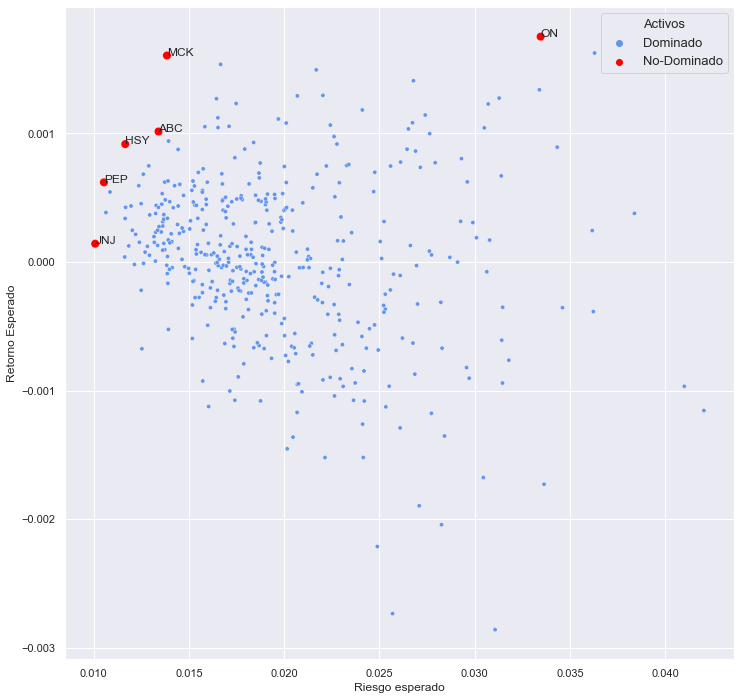

In [29]:
my_plotting.plot_assets(assets_info, best_assets)


## Segunda Parte Definición del Problema

In [30]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES)

100%|██████████| 6/6 [00:00<00:00,  7.59it/s]


## Tercera parte solución con pesos aleatorios

Total (3003, 6)


3003it [00:00, 26112.07it/s]


Mejores (55, 2)


3003it [00:00, 15640.83it/s]


Eps-Mejores (180, 2)


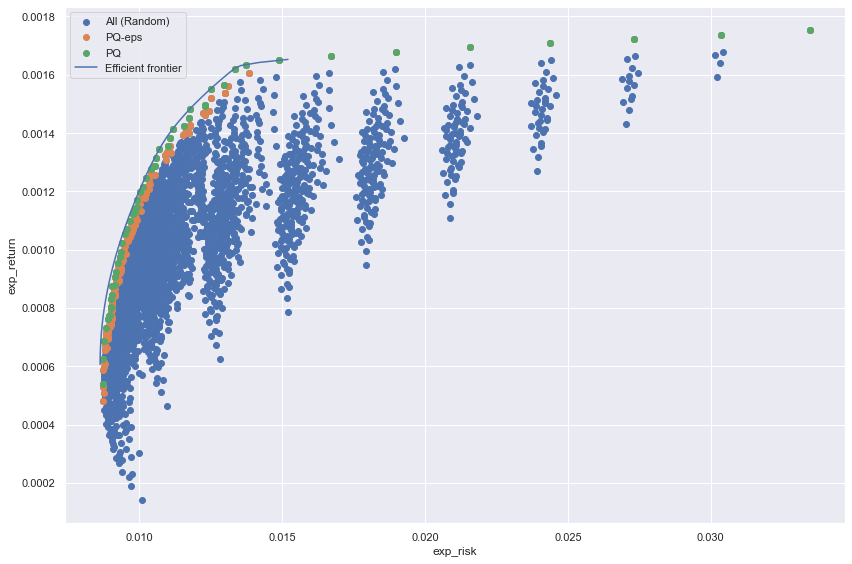

In [31]:
Xrandom_weights = get_reference_directions("das-dennis", len(PROFITS), n_partitions=10)
Frandom, ESGrandom = pymoo_extras.eval_weights(portfolio_problem, Xrandom_weights)
print('Total', Xrandom_weights.shape)
eps = np.array([1,1])/(252*100)
Frandom_best = ArchievingStrategies.get_best_opt(Frandom, 1e-8)
print('Mejores', Frandom_best.shape)
Frandom_best_eps = ArchievingStrategies.get_best_opt_eps(Frandom, 1e-8, eps)
print('Eps-Mejores', Frandom_best_eps.shape)
#Frandom_best_H   = ArchievingStrategies.get_best_opt_eps_H(Frandom, 1e-8, [0, 0], 0.01) #Muy sensible a las normas 
frames = [Frandom, Frandom_best_eps, Frandom_best]
labels = ['All (Random)', 'PQ-eps', 'PQ', 'PQ-eps-H']
my_plotting.plotting_samples(PROFITS, RISK, frames, labels, (12,8))

180it [00:00, 8999.79it/s]


(108, 3)


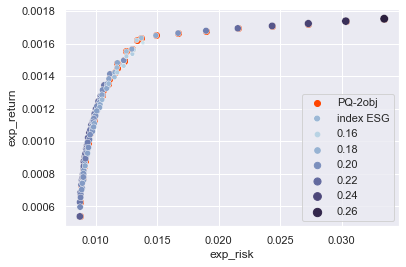

In [39]:
Frandom_best_3d =get_plot_best_opt_3d( Frandom_best_eps, ESGrandom)
print(Frandom_best_3d.shape)
plot_projection_ESG(Frandom_best, Frandom_best_3d)

## Cuarta parte solución con pesos obtenidos por medio de un algoritmo de optimización

In [40]:
#Criterio para terminar (300 generaciones)
from pymoo.termination import get_termination
termination = get_termination("n_gen", 300)
ref_dirs = get_reference_directions("energy", 2, n_points=99)
from pymoo.algorithms.moo.nsga2 import NSGA2
nsgaii = NSGA2(pop_size=25,repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.sms import SMSEMOA
smsemoa = SMSEMOA(pop_size=25, repair=pymoo_extras.Portfolio_Repair())
#from pymoo.algorithms.moo.nsga3 import NSGA3
#nsgaiii = NSGA3(pop_size=25,ref_dirs=ref_dirs, repair=pymoo_extras.Portfolio_Repair())
#from pymoo.algorithms.moo.moead import MOEAD
#moead = MOEAD( ref_dirs=ref_dirs, repair=pymoo_extras.Portfolio_Repair())

Totales (7500, 6)


7500it [00:00, 14231.47it/s]


Mejores (961, 2)


7500it [00:03, 2269.78it/s]


Mejores-Eps (5703, 2)


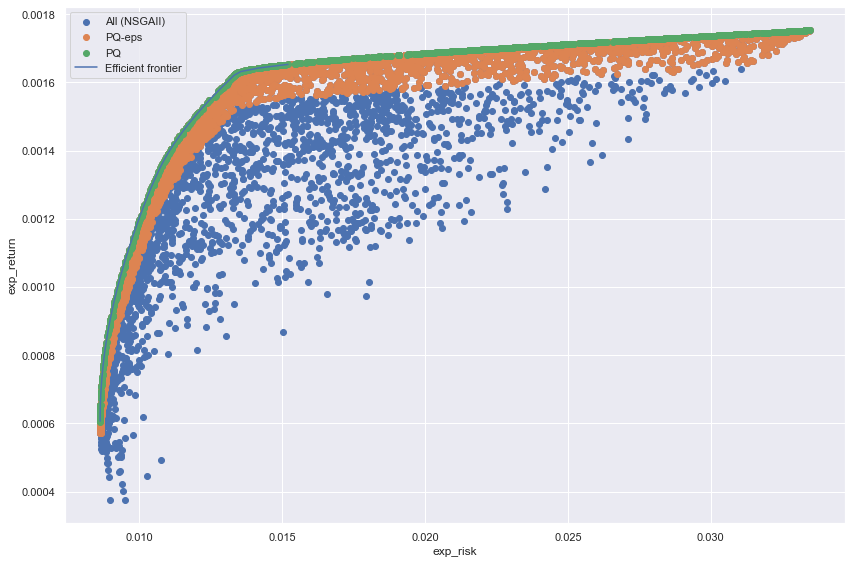

In [41]:
#En la segunda entrada se puede cambiar el algoritmo a utilizar por alguno de los definidos arriba 
#nsgaii, smsemoa, nsgaiii, moead, los que dan mejores resultados son nsgaii y smsemoa 
X_nsgaii, pdF_nsgaii, esg_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
print('Totales', X_nsgaii.shape)
pdF_best_nsgaii = ArchievingStrategies.get_best_opt(pdF_nsgaii, 1e-8)
print('Mejores', pdF_best_nsgaii.shape)
pdF_best_eps_nsgaii = ArchievingStrategies.get_best_opt_eps(pdF_nsgaii, 1e-8, [0.00001, 0.0001])
print('Mejores-Eps', pdF_best_eps_nsgaii.shape)
#pdF_best_H   = ArchievingStrategies.get_best_opt_eps_H(pdF, 1e-8, [0, 0], 0.01) #Muy sensible a las normas 
frames = [pdF_nsgaii, pdF_best_eps_nsgaii, pdF_best_nsgaii]
labels = ['All (NSGAII)', 'PQ-eps', 'PQ']
my_plotting.plotting_samples(PROFITS, RISK, frames, labels, (12,8))

5793it [00:00, 7533.17it/s]


(1503, 3)


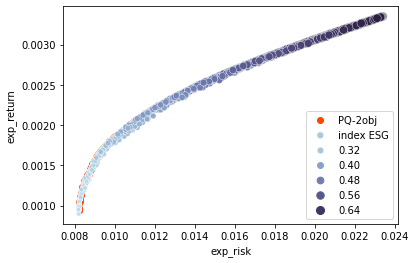

In [33]:
pdF_best_3d_nsgaii =get_plot_best_opt_3d( pdF_best_eps_nsgaii, esg_nsgaii)
print(pdF_best_3d_nsgaii.shape)
plot_projection_ESG( pdF_best_nsgaii, pdF_best_3d_nsgaii)

Totales (7500, 7)


7500it [00:00, 7970.64it/s]


Mejores (1384, 2)


7500it [00:04, 1629.30it/s]


Mejores-Eps (6652, 2)


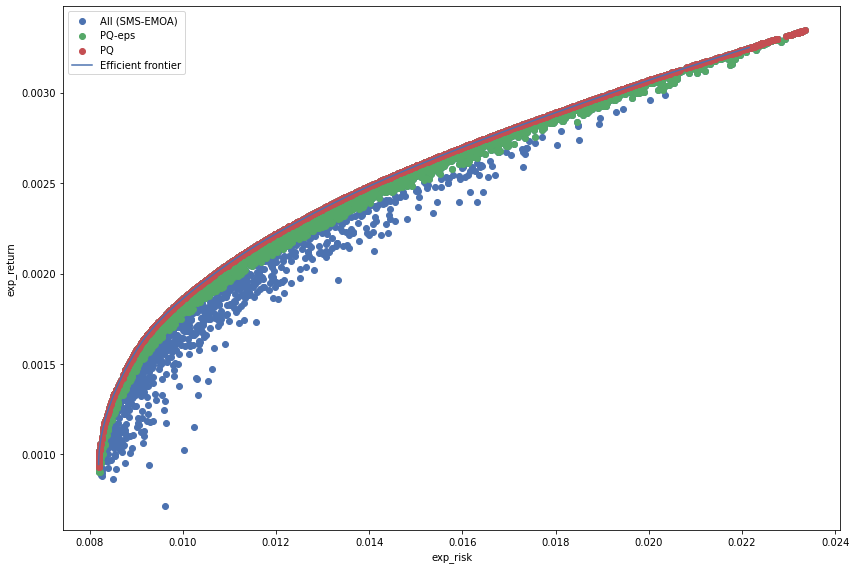

In [34]:
X_smsemoa, pdF_smsemoa, esg_smsemoa =pymoo_extras.get_weights_with_pymoo(portfolio_problem, smsemoa, termination)
print('Totales', X_smsemoa.shape)
pdF_best_smsemoa = ArchievingStrategies.get_best_opt(pdF_smsemoa, 1e-8)
print('Mejores', pdF_best_smsemoa.shape)
pdF_best_eps_smsemoa = ArchievingStrategies.get_best_opt_eps(pdF_smsemoa, 1e-8, [0.00001, 0.0001])
print('Mejores-Eps', pdF_best_eps_smsemoa.shape)
#pdF_best_H   = ArchievingStrategies.get_best_opt_eps_H(pdF, 1e-8, [0, 0], 0.01) #Muy sensible a las normas 
frames = [pdF_smsemoa, pdF_best_eps_smsemoa, pdF_best_smsemoa]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
my_plotting.plotting_samples(PROFITS, RISK, frames, labels, (12,8))

6652it [00:01, 4075.98it/s]


(2763, 3)


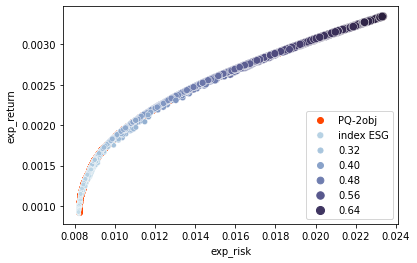

In [35]:
pdF_best_3d_smsemoa =get_plot_best_opt_3d( pdF_best_eps_smsemoa, esg_smsemoa)
print(pdF_best_3d_smsemoa.shape)
plot_projection_ESG( pdF_best_smsemoa, pdF_best_3d_smsemoa)